# 06 - City Spending Allocation

Break down city spending into investment vs cost categories for the top 100 US cities.

**Investment** (produces returns): education, infrastructure, public safety, parks, health

**Cost** (consumptive): welfare, pensions, debt service, general admin

**Data source:** Census Local Government Finances (embedded fallback)

**Output:** `city_spending.csv`, `city_spending.json`

In [1]:
import sys, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

sys.path.insert(0, str(Path("..").resolve()))
from src.city_data_utils import get_top_100_cities, fetch_city_spending

PROCESSED_DIR = Path("../data/processed")
CHARTS_DIR = Path("../docs/charts/data")
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
CHARTS_DIR.mkdir(parents=True, exist_ok=True)

# Load city data
cities = get_top_100_cities()
print(f"{len(cities)} cities loaded")

100 cities loaded


In [2]:
# Fetch spending data
spending = fetch_city_spending()

# Merge with city data
combined = cities.merge(spending, on="city_state", how="inner")

print(f"Cities with spending data: {len(combined)}")
print(f"Investment ratio range: {combined['investment_ratio'].min():.1%} \u2013 {combined['investment_ratio'].max():.1%}")
print(f"Mean investment ratio: {combined['investment_ratio'].mean():.1%}")
print(f"Per-capita total spending range: ${combined['spending_per_capita'].min():,.0f} \u2013 ${combined['spending_per_capita'].max():,.0f}")

# Display with readable units
display_df = combined[["city_state", "investment_per_capita", "cost_per_capita",
                        "spending_per_capita", "investment_ratio"]].copy()
display_df["investment_per_capita"] = display_df["investment_per_capita"].apply(lambda x: f"${x:,.0f}")
display_df["cost_per_capita"] = display_df["cost_per_capita"].apply(lambda x: f"${x:,.0f}")
display_df["spending_per_capita"] = display_df["spending_per_capita"].apply(lambda x: f"${x:,.0f}")
display_df["investment_ratio"] = combined["investment_ratio"].apply(lambda x: f"{x:.1%}")
display_df.sort_values("city_state").head(10)

Using embedded city spending data
Cities with spending data: 100
Investment ratio range: 46.0% – 63.0%
Mean investment ratio: 55.9%
Per-capita total spending range: $1,654 – $13,456


,city_state,investment_per_capita,cost_per_capita,spending_per_capita,investment_ratio
30,"Albuquerque, NM","$1,463","$1,104","$2,567",57.0%
53,"Anaheim, CA","$1,548","$1,217","$2,765",56.0%
47,"Arlington, TX","$1,407",$938,"$2,345",60.0%
35,"Atlanta, GA","$2,421","$2,146","$4,567",53.0%
51,"Aurora, CO","$1,384",$961,"$2,345",59.0%
10,"Austin, TX","$1,973","$1,261","$3,234",61.0%
49,"Bakersfield, CA","$1,069",$807,"$1,876",57.0%
28,"Baltimore, MD","$3,010","$3,533","$6,543",46.0%
92,"Baton Rouge, LA","$1,714","$1,520","$3,234",53.0%
88,"Boise, ID","$1,430",$915,"$2,345",61.0%


In [3]:
# Export to CSV and JSON
export_cols = ["city", "city_state", "state", "population", "lat", "lon",
               "spending_per_capita", "investment_per_capita", "cost_per_capita",
               "investment_ratio"]
out = combined[export_cols].sort_values("city_state").reset_index(drop=True)

csv_path = PROCESSED_DIR / "city_spending.csv"
out.to_csv(csv_path, index=False)
print(f"Wrote {csv_path}")

json_path = CHARTS_DIR / "city_spending.json"
out.to_json(json_path, orient="records", indent=2)
print(f"Wrote {json_path}")

Wrote ../data/processed/city_spending.csv
Wrote ../docs/charts/data/city_spending.json


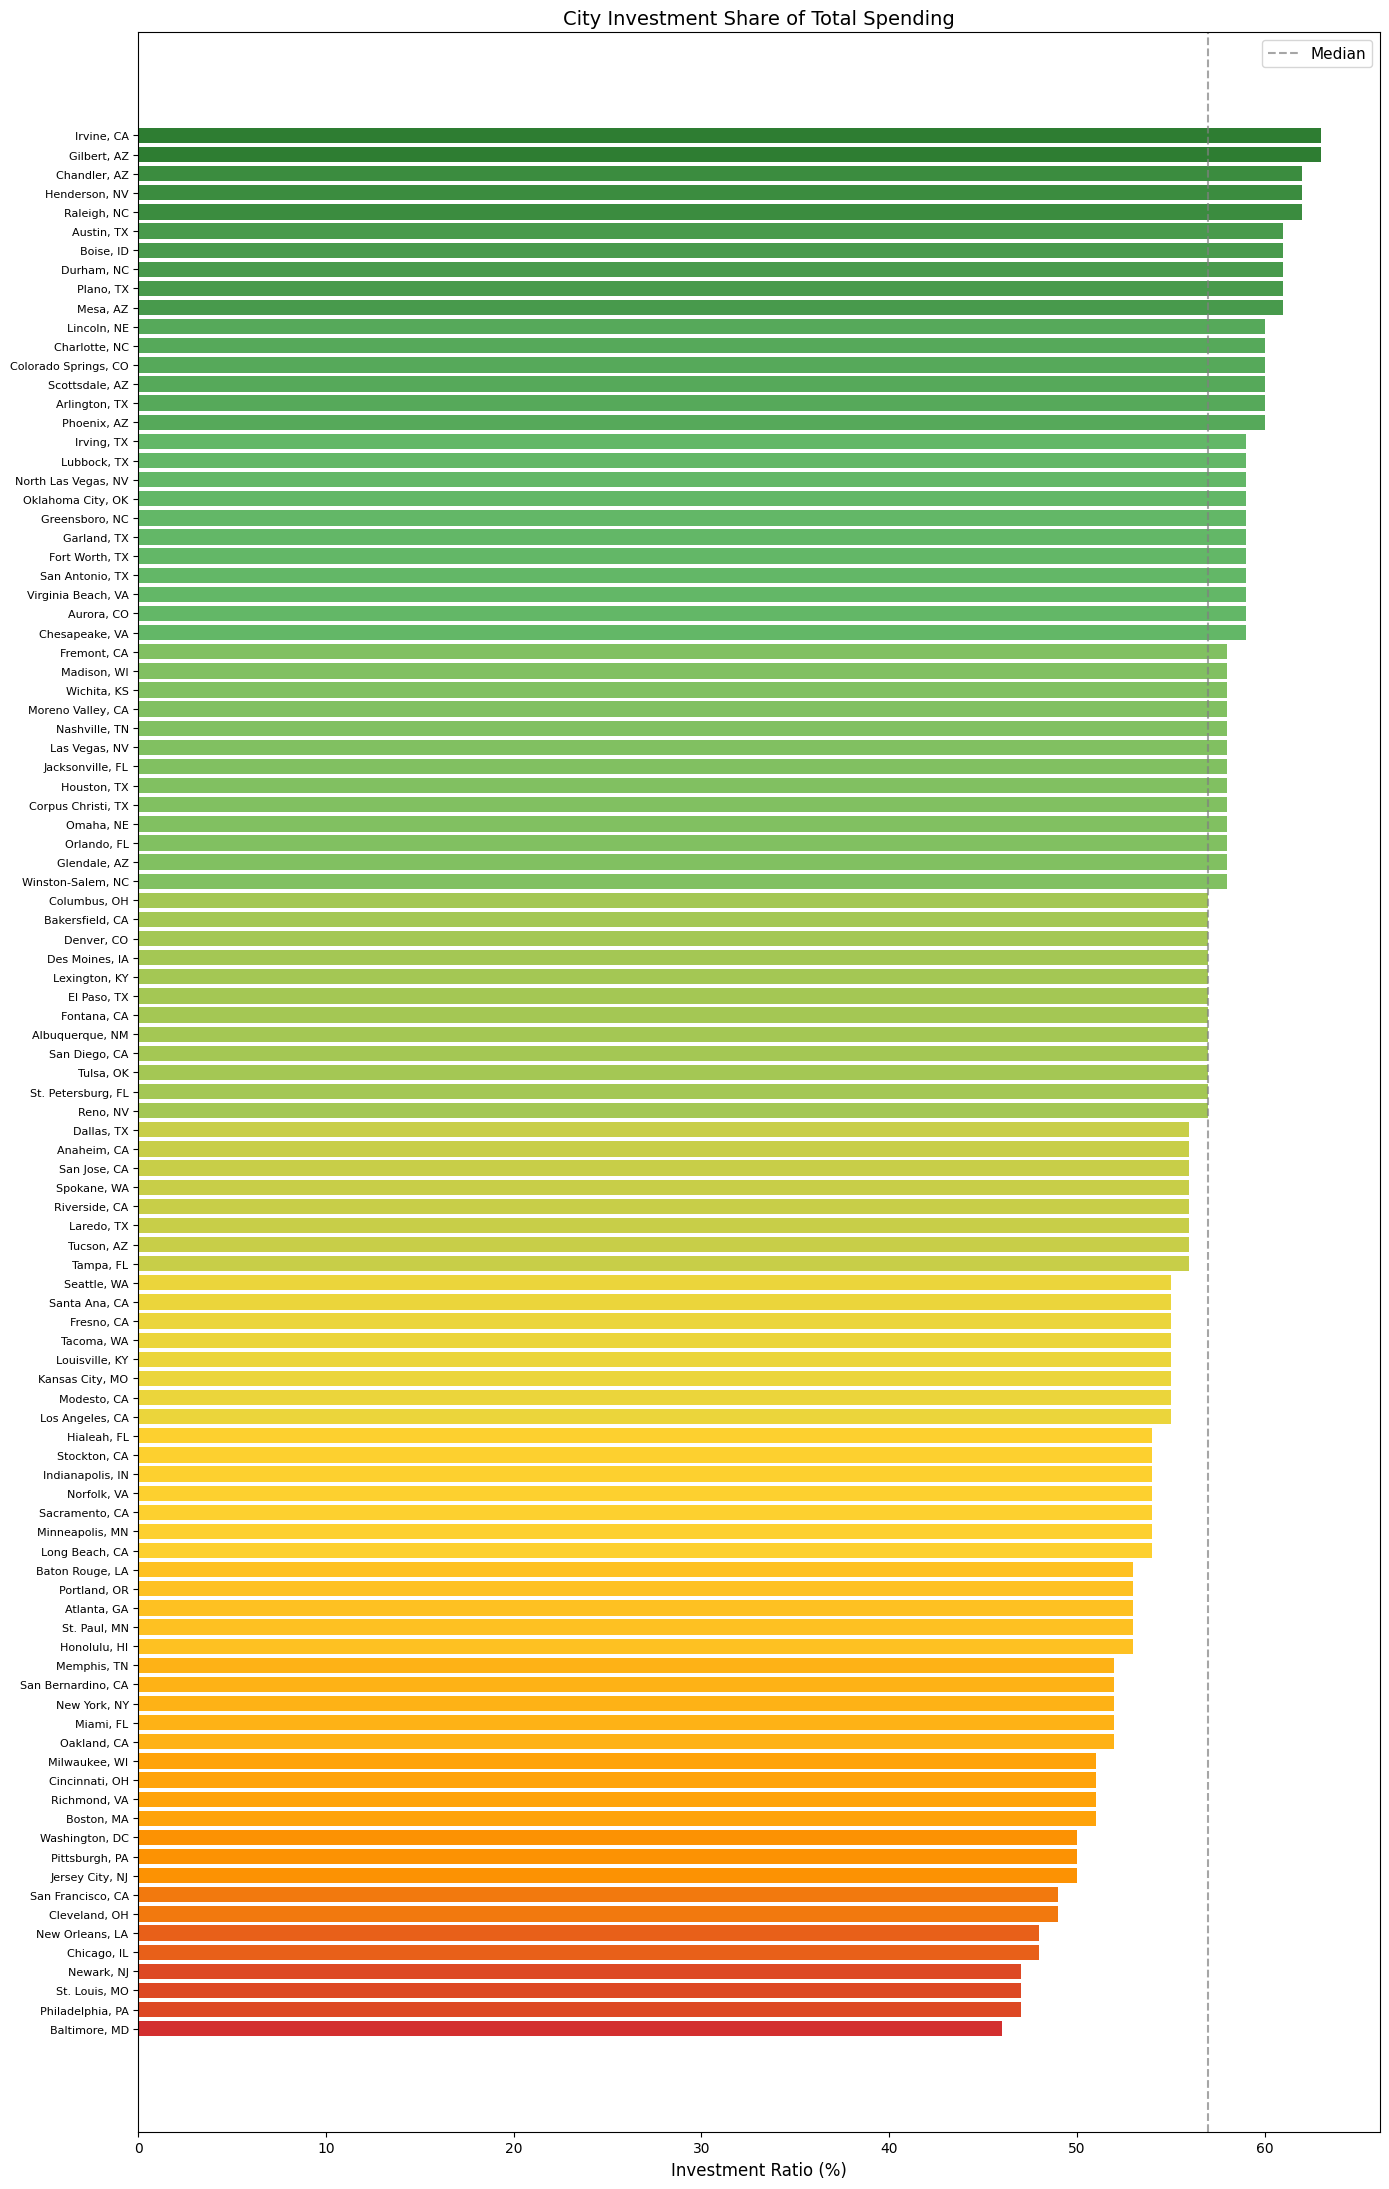

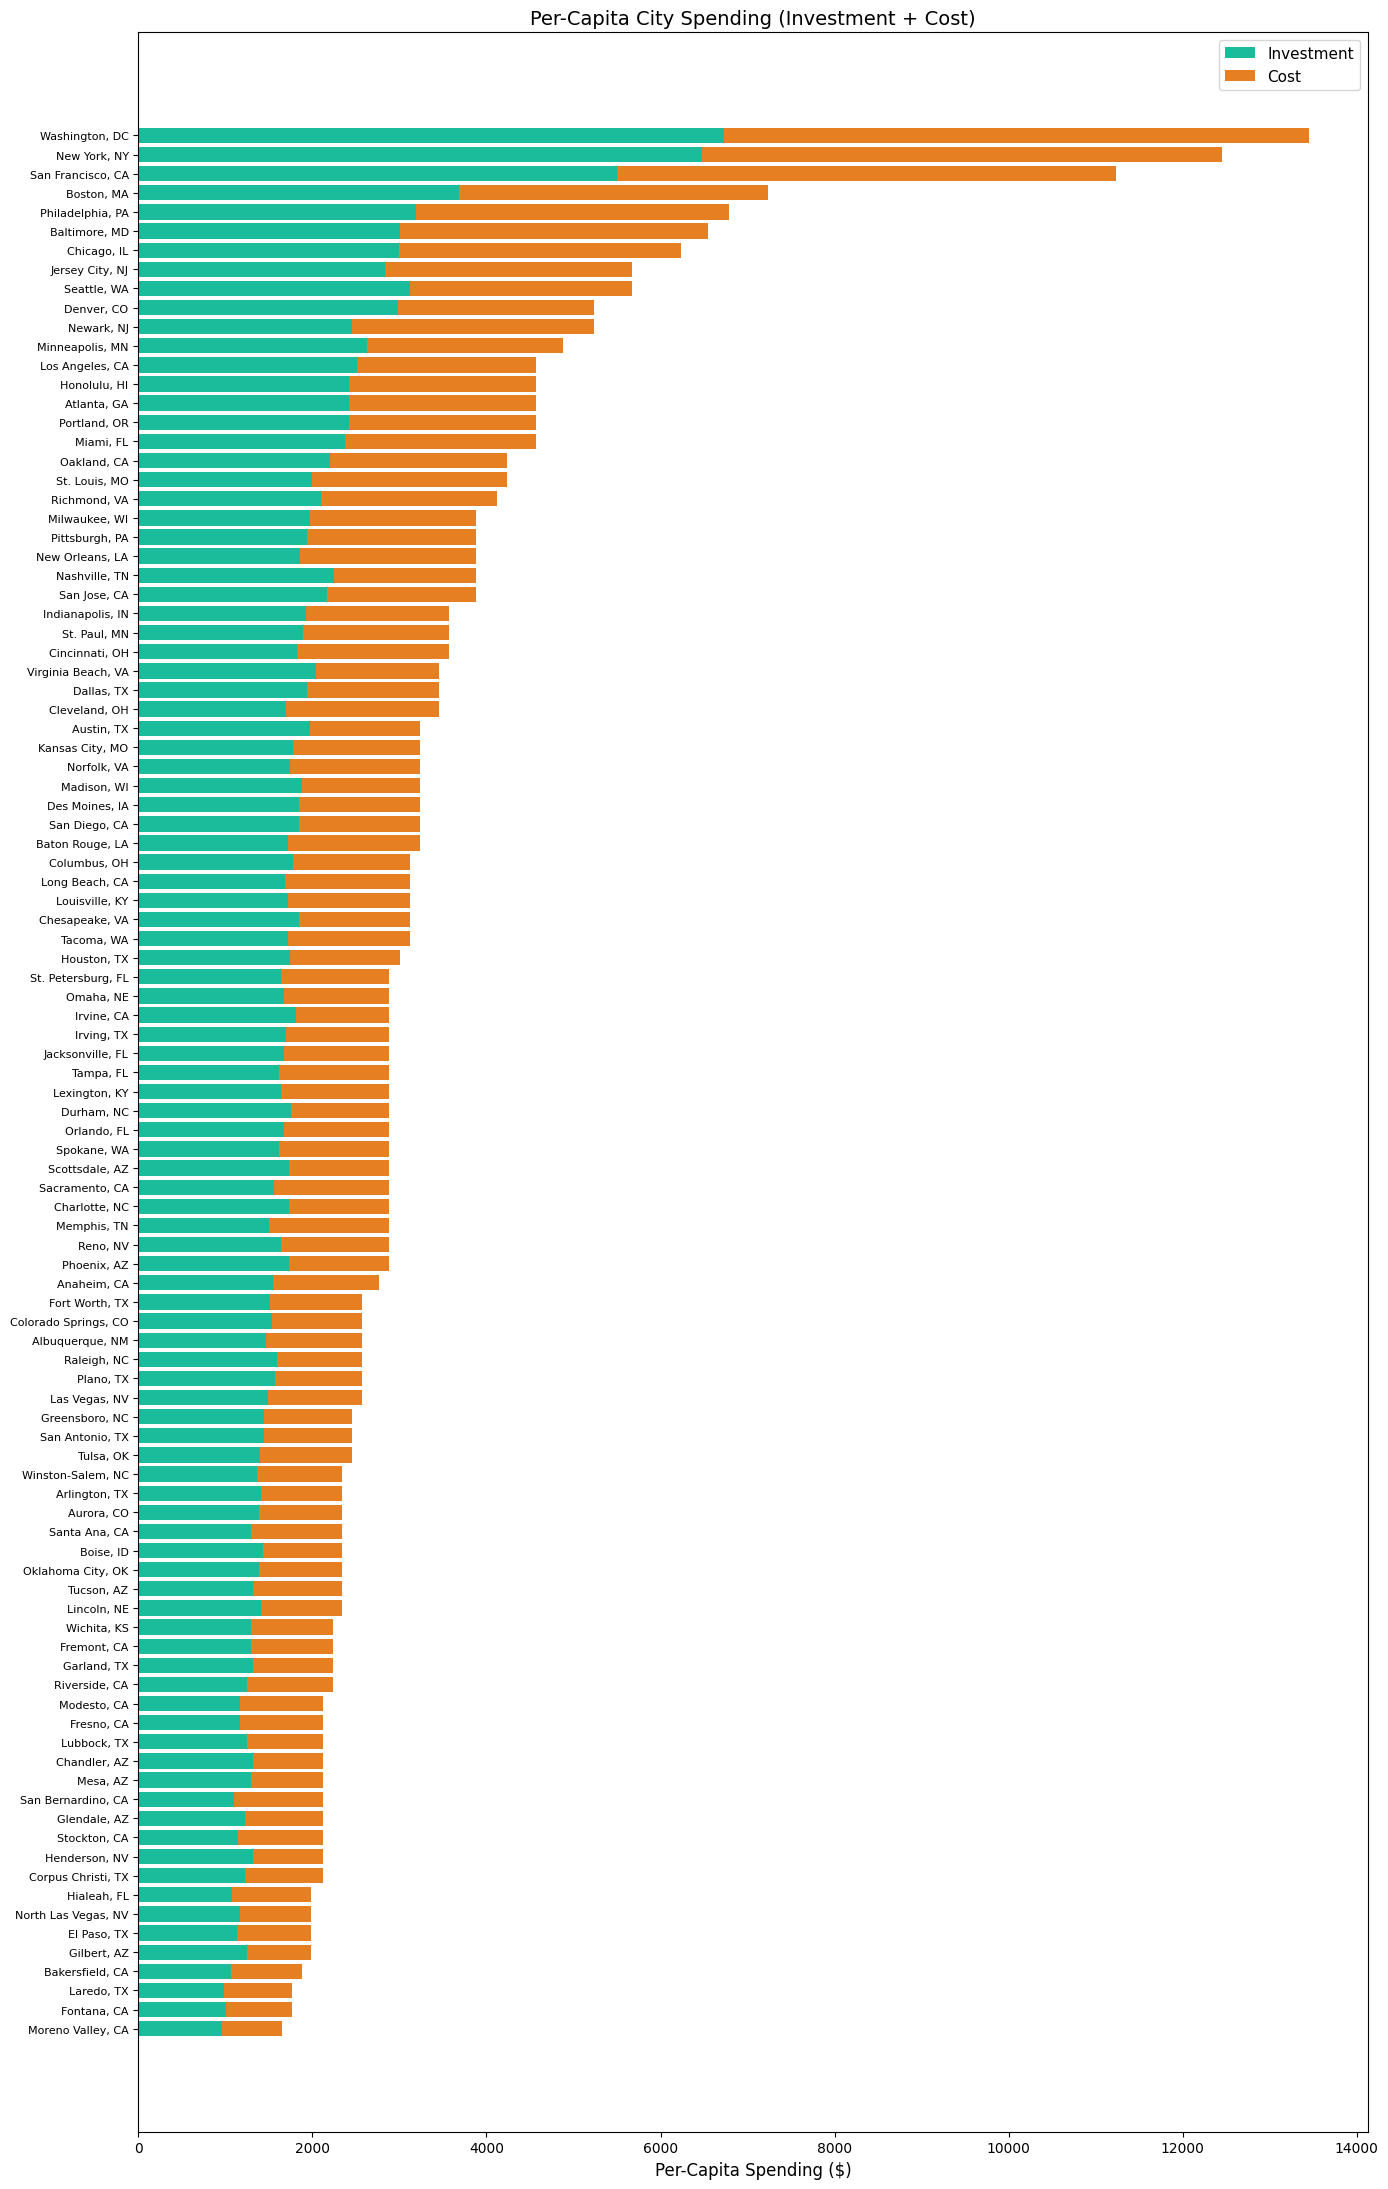

In [4]:
from matplotlib.colors import LinearSegmentedColormap
SCORE_CMAP = LinearSegmentedColormap.from_list("score", ["#d32f2f", "#ff9800", "#fdd835", "#66bb6a", "#2e7d32"])

# 1. Investment ratio by city
fig, ax = plt.subplots(figsize=(14, 22))
plot_data = out.sort_values("investment_ratio", ascending=True)
norm = (plot_data["investment_ratio"] - plot_data["investment_ratio"].min()) / \
       (plot_data["investment_ratio"].max() - plot_data["investment_ratio"].min())
colors = SCORE_CMAP(norm)
ax.barh(plot_data["city_state"], plot_data["investment_ratio"] * 100, color=colors)
ax.set_xlabel("Investment Ratio (%)", fontsize=12)
ax.set_title("City Investment Share of Total Spending", fontsize=14)
ax.axvline(x=plot_data["investment_ratio"].median() * 100,
           color="gray", linestyle="--", alpha=0.7, label="Median")
ax.tick_params(axis="y", labelsize=8)
ax.legend(["Median"], fontsize=11)
plt.tight_layout()
plt.show()

# 2. Per-capita total spending (stacked investment + cost)
fig, ax = plt.subplots(figsize=(14, 22))
plot_data2 = out.sort_values("spending_per_capita", ascending=True)
ax.barh(plot_data2["city_state"], plot_data2["investment_per_capita"], color="#1abc9c", label="Investment")
ax.barh(plot_data2["city_state"], plot_data2["cost_per_capita"],
         left=plot_data2["investment_per_capita"], color="#e67e22", label="Cost")
ax.set_xlabel("Per-Capita Spending ($)", fontsize=12)
ax.set_title("Per-Capita City Spending (Investment + Cost)", fontsize=14)
ax.tick_params(axis="y", labelsize=8)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

In [5]:
import plotly.express as px

SCORE_SCALE = [[0, "#d32f2f"], [0.25, "#ff9800"], [0.5, "#fdd835"], [0.75, "#66bb6a"], [1, "#2e7d32"]]

fig = px.scatter_geo(
    out,
    lat="lat",
    lon="lon",
    color="investment_ratio",
    size="population",
    color_continuous_scale=SCORE_SCALE,
    scope="usa",
    hover_name="city_state",
    hover_data={
        "lat": False,
        "lon": False,
        "investment_ratio": ":.1%",
        "investment_per_capita": ":$,.0f",
        "cost_per_capita": ":$,.0f",
        "spending_per_capita": ":$,.0f",
        "population": ":,.0f",
    },
    labels={
        "investment_ratio": "Inv. Ratio",
        "investment_per_capita": "Investment/Capita",
        "cost_per_capita": "Cost/Capita",
        "spending_per_capita": "Total/Capita",
        "population": "Population",
    },
    title="City Spending \u2014 Investment Ratio (green=higher)",
    size_max=30,
)
fig.update_layout(
    coloraxis_colorbar=dict(title="Inv. Ratio", tickformat=".0%"),
    geo=dict(lakecolor="rgb(255,255,255)"),
)
fig.show()